In [3]:
# We will need some functionality 
from typing import List 

import time

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter

from qiskit.circuit import Parameter

import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()


<ipython-input-3-9140d5ec75e4>:34: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


In [4]:
from ipynb.fs.full.da_vqe import analog_ansatz, get_conv_time, get_eigenvalue, get_ham_operator, get_ham_operator, plot_connectivity, get_connections_matrix, digital_ansatz

In [5]:
# noise_model = None
# device = QasmSimulator.from_backend(device_backend)
# coupling_map = device.configuration().coupling_map
# noise_model = NoiseModel.from_backend(device)
# basis_gates = noise_model.basis_gates

        ┌────────┐┌────────┐┌───────────────┐ ░ 
q155_0: ┤ Rx(a0) ├┤ Rz(b0) ├┤0              ├─░─
        ├────────┤└────────┘│  analog block │ ░ 
q155_1: ┤ Rz(b1) ├──────────┤1              ├─░─
        └────────┘          └───────────────┘ ░ 
     ┌────────┐┌────────┐     ┌───┐ ░ 
q_0: ┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├─░─
     ├────────┤└────────┘┌─┴─┐└─┬─┘ ░ 
q_1: ┤ Rz(b1) ├──────────┤ X ├──■───░─
     └────────┘          └───┘      ░ 
Analog Eigenvalue 1.8355761878222734, Conv Time 0.998001998001998
Digital Eigenvalue 1.0662954190509928, Conv Time 0.998001998001998
        ┌────────┐┌────────┐┌───────────────┐┌───────────────┐ ░ 
q186_0: ┤ Rx(a0) ├┤ Rz(b0) ├┤0              ├┤0              ├─░─
        ├────────┤└────────┘│  analog block ││  analog block │ ░ 
q186_1: ┤ Rz(b1) ├──────────┤1              ├┤1              ├─░─
        └────────┘          └───────────────┘└───────────────┘ ░ 
     ┌────────┐┌────────┐     ┌───┐     ┌───┐ ░ 
q_0: ┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├──■──┤ X ├─░─

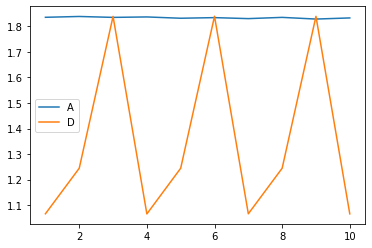

In [7]:
H2_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
ham_block = HamiltonianGate(data=H2_op, time=2)
chosen_op = H2_op

qubits_count = 2

seed = 170
iterations = 500
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 
#qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         #coupling_map=coupling_map, noise_model=noise_model, 
                         #measurement_error_mitigation_cls=CompleteMeasFitter, 
                         #cals_matrix_refresh_period=30)

dig_eigs = []
ana_eigs = []
block_choices = [1,2,3,4,5,6,7,8,9,10]
for blocks in block_choices:
    printing = True
    ana_dats = get_eigenvalue("analog",qubits_count,chosen_op,qi,iterations,blocks,ham_block,printing)
    dig_dats = get_eigenvalue("digital",qubits_count,chosen_op,qi,iterations,blocks,ham_block,printing)
    dig_eigs.append(dig_dats[0])
    ana_eigs.append(ana_dats[0])
    
    print("Analog Eigenvalue {},".format(ana_dats[0]),"Conv Time {}".format(ana_dats[2]))
    print("Digital Eigenvalue {},".format(dig_dats[0]),"Conv Time {}".format(dig_dats[2]))
    #plt.plot(ana_dats[1],label="A")
    #plt.plot(dig_dats[1],label="D{}".format(blocks))
    #plt.legend()
    #plt.title("Convergence Series")
    #plt.show()
    
plt.plot(block_choices,ana_eigs,label="A")
plt.plot(block_choices,dig_eigs,label="D")
plt.legend()
plt.show()